In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
null_count = df.isnull().sum()
null_count[null_count > 0]

ctz      30740
state     2576
city         1
dtype: int64

In [5]:
# drop 'ctz' because majority of this column is NaN
df.drop('ctz', axis = 1, inplace = True)

In [6]:
df.select_dtypes(include = ['object']).head()

,10k,name,25k,gender,bib,35k,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",47.67,M,W1,71.40,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",82.43,F,F1,116.37,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",45.80,M,W2,67.42,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",82.43,F,F2,116.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",46.37,M,W3,67.83,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


    Recommendation: make the objects into binary variable
        if too many unique classes, then just get rid of it

In [7]:
# get rid of '-'
df = df.replace('-', '') 

# convert to float types
dis = ['5k', '10k', '20k', '25k', '30k', '35k', '40k', 'half']
for i in dis:
    df[i] = pd.to_numeric(df[i]).astype(float)

In [17]:
df_no_obj = df.select_dtypes(exclude = ['object'])

In [18]:
# discover the null values in 'df_no_obj'
null_count = df_no_obj.isnull().sum()
null_count[null_count > 0]

10k      50
25k     216
35k      34
30k      40
5k       52
half     72
20k      51
40k      39
dtype: int64

In [19]:
# drop the null values
df_no_obj = df_no_obj.dropna(axis = 0, how = 'any')

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# normalize data
scaler = MinMaxScaler()
df_no_obj = scaler.fit_transform(df_no_obj)

# use pca to reduce feature to 2 components
X_pca = PCA(2).fit_transform(df_no_obj)


In [21]:
# this is subsampling
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(
    X_pca,
    test_size = 0.9)

***
### Mean-Shift
***

#### normlized data => bandwidth between 0 - 1

* higher samples => larger bandwidth
* lower quantile => smaller bandwidth
        note: with higher sample, quantile can go lower, which can result in smaller bandwidth
               

0.293570931853
Number of Clusters: 3


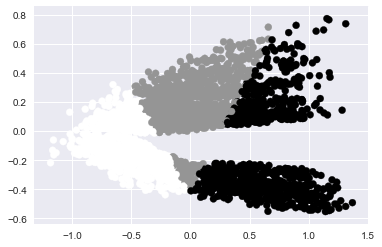

In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train, quantile= 0.13, n_samples = 1000)
print(bandwidth)

# declare and fit model
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True).fit(X_train)

# extract cluster assignments for data points
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# count number of clusters
n_clusters = len(np.unique(labels))
print('Number of Clusters: {}'.format(n_clusters))

# Plot the solution.
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

    Use PCA to reduce components to 2 for graphing

***
### Spectral Cluster
***

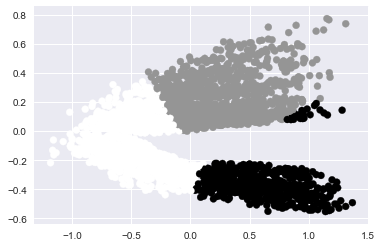

In [39]:
from sklearn.cluster import SpectralClustering

# set number of clusters to 3
n_clusters=3

# declare and fit the model.
sc = SpectralClustering(n_clusters = n_clusters).fit(X_train)

# predicted clusters.
pred = sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c = pred)
plt.show()

***
### Affinity Propagation
***

In [40]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# declare and fit model
af = AffinityPropagation().fit(X_train)
print('Done')

# the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 651


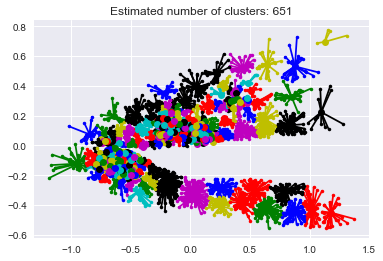

In [41]:
from itertools import cycle

plt.clf()

# cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

***
### K-Means
***

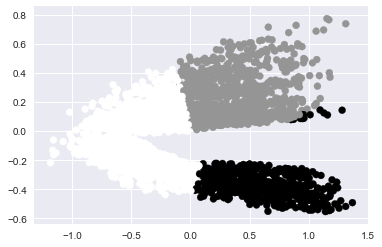

In [42]:
from sklearn.cluster import KMeans

# calculate predicted values
pred = KMeans(n_clusters = 3, random_state = 42).fit_predict(X_train)

# Plot the solution.
plt.scatter(X_train[:, 0], X_train[:, 1], c = pred)
plt.show()

In [43]:
# create a list of pairs, where each pair is the ground truth group and the assigned cluster.
c = list(itertools.product(y, pred))

NameError: name 'y' is not defined

### No Target Variable
    how to do this step above?